### Generate submission csv

---

In [1]:
import re
import keras
import numpy as np
import pandas as pd
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
SAMPLE_SIZE = 20486
MODEL_FILE = '/d3/caches/kaggle-painters-v3/models/N/e806-l=0.04157-vl=0.03344-a=0.98507-va=0.98807.h5' # V2
HSS_CACHE_FILE = 'out/halfsamples.npy'

In [3]:
hss_cache = np.load(HSS_CACHE_FILE).item()

# create sample from bottlecks, dpi and ARs of a pair
def create_pair_sample(fid1, fid2):
    
    hs1 = hss_cache[fid1]
    hs2 = hss_cache[fid2]
    
    return np.hstack((hs1, hs2))

In [4]:
# load submission info
test_df = pd.read_csv('submission_info.csv', index_col='index')

# convert image filenames to fids
test_df['image1'] = [int(re.findall(r'(\d+).jpg$', x)[0]) for x in test_df['image1']]
test_df['image2'] = [int(re.findall(r'(\d+).jpg$', x)[0]) for x in test_df['image2']]

In [5]:
# load model
model = keras.models.load_model(MODEL_FILE)

In [6]:
# create dataframe for submission
subm_df = pd.DataFrame({'index': np.array([], dtype=np.int64), 'sameArtist': np.array([], dtype=np.float32)})
subm_df = subm_df.set_index('index')

In [7]:
N = 100000 # samples per batch
batch_no = 0
batch_features = np.zeros([N, SAMPLE_SIZE], dtype=np.float32)
batch_test_indexes = []

In [ ]:
def dump_batch():
    global batch_test_indexes
    global batch_features
    global batch_no
    global subm_df
    global N
    
    batch_no = batch_no + 1
    
    y_p = model.predict(
        batch_features[:len(batch_test_indexes)],
        verbose=False
    )

    batch_df = pd.DataFrame({
        'index': batch_test_indexes,
        'sameArtist': y_p.T[0]
    })
    
    batch_df = batch_df.set_index('index')
    subm_df = subm_df.append(batch_df)
    
    batch_features = np.zeros([N, SAMPLE_SIZE], dtype=np.float32)
    batch_test_indexes = []

In [ ]:
for row in tqdm(test_df.iterrows()):
    
    test_index = int(row[0])
    fid1 = row[1]['image1']
    fid2 = row[1]['image2']
    
    ix = len(batch_test_indexes)
    batch_test_indexes.append(test_index)
    batch_features[ix] = create_pair_sample(fid1, fid2)

    if len(batch_test_indexes) == N: 
        dump_batch()

if len(batch_test_indexes) > 0: dump_batch()
    
# del batch_test_indexes
# del batch_features

458226it [01:06, 13632.21it/s]

In [ ]:
subm_df.to_csv('submission.csv', index=True, float_format='%.8f')

(array([ 21417888.,    498159.]),
 array([ 0. ,  0.5,  1. ]),
 <a list of 2 Patch objects>)

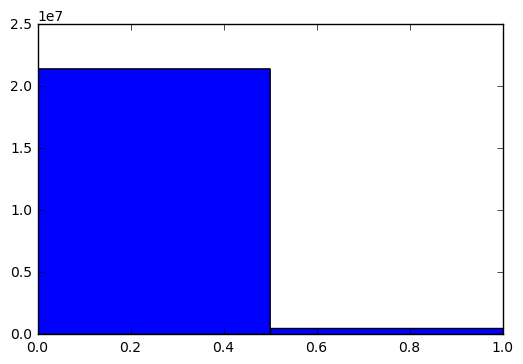

In [11]:
plt.hist(subm_df['sameArtist'].values, bins=2)